# 14. 시퀀스 레이블링

### 14-02 양방향 LSTM을 이용한 개체명 인식

In [1]:
# NLTK에서 개체명 인식기 지원
from nltk import word_tokenize, pos_tag, ne_chunk

### 3. 인공 신경망을 이용하여 개체명 인식 모델을 만들어봄

##### 1. 데이터 로드 및 단어 토큰화

In [2]:
import urllib.request
import numpy as np
from tqdm import tqdm
import re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/12.%20RNN%20Sequence%20Labeling/dataset/train.txt", filename="/Users/zoohunn/Desktop/비어플/[26-1]스터디/3주차/train.txt")

('/Users/zoohunn/Desktop/비어플/[26-1]스터디/3주차/train.txt',
 <http.client.HTTPMessage at 0x147bb4e50>)

In [5]:
# 전처리 후 전체 문장 샘플의 개수 확인
f = open('/Users/zoohunn/Desktop/비어플/[26-1]스터디/3주차/train.txt')
tagged_sentences = []
sentence = []

for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue
    splits = line.split(' ') # 공백을 기준으로 속성을 구분한다.
    splits[-1] = re.sub(r'\n', '', splits[-1]) # 줄바꿈 표시 \n을 제거한다.
    word = splits[0].lower() # 단어들은 소문자로 바꿔서 저장한다.
    sentence.append([word, splits[-1]]) # 단어와 개체명 태깅만 기록한다.

In [6]:
print("전체 샘플 개수: ", len(tagged_sentences)) # 전체 샘플의 개수 출력

전체 샘플 개수:  14041


In [7]:
print(tagged_sentences[0]) # 첫 번째 샘플 출력

[['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


In [8]:
# 각 문장 샘플에 대해, 단어는 sentences에, 태깅 정보는 pos_tags에 저장
sentences, ner_tags = [], []
for tagged_sentence in tagged_sentences: # 14,041개의 문장 샘플을 1개씩 불러옴
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에, 개체명 태깅 정보들은 tag_info에 저장
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장

In [9]:
print(sentences[0]) # 첫 번째 샘플의 단어 정보 출력
print(ner_tags[0]) # 첫 번째 샘플의 개체명 태깅 정보 출력

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


In [10]:
print(sentences[12]) 
print(ner_tags[12])

['only', 'france', 'and', 'britain', 'backed', 'fischler', "'s", 'proposal', '.']
['O', 'B-LOC', 'O', 'B-LOC', 'O', 'B-PER', 'O', 'O', 'O']


In [11]:
X_train, X_test, y_train, y_test = train_test_split(sentences, ner_tags, test_size=0.2, random_state=777)

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=777)

In [13]:
print('훈련 데이터의 개수 :', len(X_train))
print('검증 데이터의 개수 :', len(X_valid))
print('테스트 데이터의 개수 :', len(X_test))
print('훈련 데이터 레이블의 개수 :', len(X_train))
print('검증 데이터 레이블의 개수 :', len(X_valid))
print('테스트 데이터 레이블의 개수 :', len(X_test))

훈련 데이터의 개수 : 8985
검증 데이터의 개수 : 2247
테스트 데이터의 개수 : 2809
훈련 데이터 레이블의 개수 : 8985
검증 데이터 레이블의 개수 : 2247
테스트 데이터 레이블의 개수 : 2809


In [14]:
# 상위 샘플 2개 출력
for sent in X_train[:2]:
    print(sent)

['young', 'boys', '9', '1', '0', '8', '6', '19', '3']
['hentgen', '(', '17-7', ')', 'surrendered', 'just', 'three', 'doubles', 'and', 'a', 'pair', 'of', 'singles', 'in', 'tossing', 'his', 'major-league', 'leading', 'ninth', 'complete', 'game', '.']


##### 2. Vocab 만들기

In [15]:
# 각 단어의 빈도수 계산
word_list = []
for sent in X_train:
    for word in sent:
        word_list.append(word)

word_counts = Counter(word_list)
print('총 단어수 :', len(word_counts))

총 단어수 : 16742


In [16]:
print('훈련 데이터에서의 단어 the의 등장 횟수 :', word_counts['the'])
print('훈련 데이터에서의 단어 love의 등장 횟수 :', word_counts['love'])

훈련 데이터에서의 단어 the의 등장 횟수 : 5410
훈련 데이터에서의 단어 love의 등장 횟수 : 7


In [17]:
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print('등장 빈도수 상위 10개 단어')
print(vocab[:10])

등장 빈도수 상위 10개 단어
['the', ',', '.', 'of', 'in', 'to', 'a', ')', '(', 'and']


In [18]:
# 단어 집합 만들기 위해 패딩을 위한 토큰, OOV 토큰 추가
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

for index, word in enumerate(vocab) :
  word_to_index[word] = index + 2

vocab_size = len(word_to_index)
print('패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 :', vocab_size)

패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 : 16744


##### 3. 정수 인코딩

In [19]:
def texts_to_sequences(tokenized_X_data, word_to_index):
  encoded_X_data = []
  for sent in tokenized_X_data:
    index_sequences = []
    for word in sent:
      try:
          index_sequences.append(word_to_index[word])
      except KeyError:
          index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data

In [20]:
encoded_X_train = texts_to_sequences(X_train, word_to_index)
encoded_X_valid = texts_to_sequences(X_valid, word_to_index)
encoded_X_test = texts_to_sequences(X_test, word_to_index)

In [21]:
# 상위 샘플 2개 출력
for sent in encoded_X_train[:2]:
  print(sent)

[1260, 3215, 117, 17, 21, 123, 56, 539, 23]
[5456, 10, 8229, 9, 8230, 186, 84, 1815, 11, 8, 1073, 5, 421, 6, 8231, 35, 2043, 291, 790, 957, 267, 4]


In [22]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

decoded_sample = [index_to_word[word] for word in encoded_X_train[0]]
print('기존의 첫번째 샘플 :', X_train[0])
print('복원된 첫번째 샘플 :', decoded_sample)

기존의 첫번째 샘플 : ['young', 'boys', '9', '1', '0', '8', '6', '19', '3']
복원된 첫번째 샘플 : ['young', 'boys', '9', '1', '0', '8', '6', '19', '3']


In [23]:
# 레이블에 대한 정수 인코딩도 진행
# y_train으로부터 존재하는 모든 태그들의 집합 구하기
flatten_tags = [tag for sent in y_train for tag in sent]
tag_vocab = list(set(flatten_tags))
print('태그 집합 :', tag_vocab)
print('태그 집합의 크기 :', len(tag_vocab))

태그 집합 : ['O', 'B-LOC', 'B-ORG', 'I-PER', 'I-MISC', 'B-MISC', 'I-ORG', 'I-LOC', 'B-PER']
태그 집합의 크기 : 9


In [24]:
tag_to_index = {}
tag_to_index['<PAD>'] = 0

for index, word in enumerate(tag_vocab) :
  tag_to_index[word] = index + 1

tag_vocab_size = len(tag_to_index)
# print('패딩 토큰까지 포함된 태그 집합의 크기 :', tag_vocab_size)
print('태그 집합 :', tag_to_index)

태그 집합 : {'<PAD>': 0, 'O': 1, 'B-LOC': 2, 'B-ORG': 3, 'I-PER': 4, 'I-MISC': 5, 'B-MISC': 6, 'I-ORG': 7, 'I-LOC': 8, 'B-PER': 9}


다대다 문제의 경우 레이블도 시퀀스 데이터가 되므로 각 레이블을 정수 시퀀스로 변환 해준다 -> 즉, 레이블에 대해서 정수 인코딩을 진행

In [26]:
def encoding_label(sequence, tag_to_index):
    label_sequence = []
    for seq in sequence:
        label_sequence.append([tag_to_index[tag] for tag in seq])
    return label_sequence

In [27]:
encoded_y_train = texts_to_sequences(y_train, tag_to_index)
encoded_y_valid = texts_to_sequences(y_valid, tag_to_index)
encoded_y_test = texts_to_sequences(y_test, tag_to_index)

In [28]:
print('X 데이터 상위 2개')
print(encoded_X_train[:2])
print('-' * 50)
print('y 데이터 상위 2개')
print(encoded_y_train[:2])
print('-' * 50)
print('첫번째 샘플과 레이블의 길이')
print(len(encoded_X_train[0]))
print(len(encoded_y_train[0]))

X 데이터 상위 2개
[[1260, 3215, 117, 17, 21, 123, 56, 539, 23], [5456, 10, 8229, 9, 8230, 186, 84, 1815, 11, 8, 1073, 5, 421, 6, 8231, 35, 2043, 291, 790, 957, 267, 4]]
--------------------------------------------------
y 데이터 상위 2개
[[3, 7, 1, 1, 1, 1, 1, 1, 1], [9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
--------------------------------------------------
첫번째 샘플과 레이블의 길이
9
9


##### 4. 패딩

샘플의 최대 길이 : 78
샘플의 평균 길이 : 14.518420


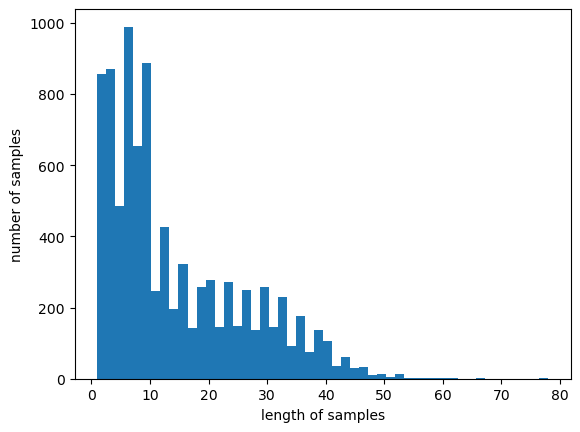

In [29]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in encoded_X_train))
print('샘플의 평균 길이 : %f' % (sum(map(len, encoded_X_train))/len(encoded_X_train)))
plt.hist([len(s) for s in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [30]:
# max_len 설정
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [31]:
max_len = 80
below_threshold_len(max_len, encoded_X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 100.0


In [32]:
# max_len 보다 짧은 데이터의 경우에는 뒤에 0을 추가하는 함수
def pad_sequences(sentences, max_len):
    features = np.zeros((len(sentences), max_len), dtype=int)
    for index, sentence in enumerate(sentences):
        if len(sentence) != 0:
            features[index, :len(sentence)] = np.array(sentence)[:max_len]
    return features

개체명 인식과 같은 many-to-many 문제를 푸는 경우 레이블도 패딩해줘야하는 것 기억

In [33]:
padded_X_train = pad_sequences(encoded_X_train, max_len=max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len=max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len=max_len)

padded_y_train = pad_sequences(encoded_y_train, max_len=max_len)
padded_y_valid = pad_sequences(encoded_y_valid, max_len=max_len)
padded_y_test = pad_sequences(encoded_y_test, max_len=max_len)

print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_valid.shape)
print('테스트 데이터의 크기 :', padded_X_test.shape)
print('-' * 30)
print('훈련 데이터의 레이블 :', padded_y_train.shape)
print('검증 데이터의 레이블 :', padded_y_valid.shape)
print('테스트 데이터의 레이블 :', padded_y_test.shape)

훈련 데이터의 크기 : (8985, 80)
검증 데이터의 크기 : (2247, 80)
테스트 데이터의 크기 : (2809, 80)
------------------------------
훈련 데이터의 레이블 : (8985, 80)
검증 데이터의 레이블 : (2247, 80)
테스트 데이터의 레이블 : (2809, 80)


In [34]:
print('훈련 데이터의 상위 샘플 2개')
print(padded_X_train[:2])
print('-' * 5 + '레이블' + '-' * 5)
print(padded_y_train[:2])

훈련 데이터의 상위 샘플 2개
[[1260 3215  117   17   21  123   56  539   23    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [5456   10 8229    9 8230  186   84 1815   11    8 1073    5  421    6
  8231   35 2043  291  790  957  267    4    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]]
-----레이블-----
[[3 7 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

##### 5. 모델링

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [36]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", device)

cpu와 cuda 중 다음 기기로 학습함: cpu


In [37]:
'''
단방향 GRU 모델인 경우,

class NERTagger(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(NERTagger, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        gru_out, _ = self.gru(embedded)  # (batch_size, seq_length, hidden_dim)
        logits = self.fc(gru_out)  # (batch_size, seq_length, output_dim)
        return logits
'''

'\n단방향 GRU 모델인 경우,\n\nclass NERTagger(nn.Module):\n    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):\n        super(NERTagger, self).__init__()\n        self.embedding = nn.Embedding(vocab_size, embedding_dim)\n        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)\n        self.fc = nn.Linear(hidden_dim, output_dim)\n\n    def forward(self, x):\n        # x: (batch_size, seq_length)\n        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)\n        gru_out, _ = self.gru(embedded)  # (batch_size, seq_length, hidden_dim)\n        logits = self.fc(gru_out)  # (batch_size, seq_length, output_dim)\n        return logits\n'

In [38]:
# 양방향 LSTM 2층 모델

class NERTagger(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=2):
        super(NERTagger, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True) # bidirectional=True -> 양방향 LSTM
        self.fc = nn.Linear(hidden_dim*2, output_dim) # hidden_dim*2 -> 양방향 LSTM이므로 hidden_dim에 2를 곱함

    def forward(self, x):
        # x: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        lstm_out, _ = self.lstm(embedded)  # (batch_size, seq_length, hidden_dim*2)
        logits = self.fc(lstm_out)  # (batch_size, seq_length, output_dim)
        return logits

In [39]:
X_train_tensor = torch.tensor(padded_X_train, dtype=torch.long)
y_train_tensor = torch.tensor(padded_y_train, dtype=torch.long)
X_valid_tensor = torch.tensor(padded_X_valid, dtype=torch.long)
y_valid_tensor = torch.tensor(padded_y_valid, dtype=torch.long)
X_test_tensor = torch.tensor(padded_X_test, dtype=torch.long)
y_test_tensor = torch.tensor(padded_y_test, dtype=torch.long)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)
valid_dataset = torch.utils.data.TensorDataset(X_valid_tensor, y_valid_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=False, batch_size=32)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=32)

In [40]:
print('단어 집합의 크기:', vocab_size)

단어 집합의 크기: 16744


In [41]:
# 하이퍼파라미터 설정
embedding_dim = 100
hidden_dim = 256
output_dim = tag_vocab_size
learning_rate = 0.01
num_epochs = 10
num_layers = 2

In [42]:
# 모델 객체 및 손실함수 및 최적화 함수 정의
model = NERTagger(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers)
model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0) # ignore_index=0을 통해 패딩 토큰에 대한 손실은 계산하지 않음
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

##### 6. 평가 코드 작성

In [43]:
# 정확도 평가 함수 정의
def calculate_accuracy(logits, labels, ignore_index=0):
    predicted = torch.argmax(logits, dim=1)                          # 예측 레이블을 구함
    mask = (labels != ignore_index)                                  # 패딩 토큰은 무시해서 계산하지 않도록 함
    correct = (predicted == labels).masked_select(mask).sum().item() # 정답을 맞춘 경우를 집계
    total = mask.sum().item()

    accuracy = correct / total
    return accuracy

In [44]:
# 검증 데이터에 대한 정확도와 loss 계산 함수 정의
def evaluate(model, valid_dataloader, criterion, device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # Forward pass
            logits = model(batch_X)

            # Compute loss
            loss = criterion(logits.view(-1, output_dim), batch_y.view(-1))

            # Calculate validation accuracy and loss
            val_loss += loss.item()
            val_correct += calculate_accuracy(logits.view(-1, output_dim), batch_y.view(-1)) * batch_y.size(0)
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_accuracy

##### 7. 모델 학습

In [46]:
num_epochs = 5

# Training loop
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for batch_X, batch_y in train_dataloader:
        # Forward pass
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        logits = model(batch_X)

        # Compute loss
        loss = criterion(logits.view(-1, output_dim), batch_y.view(-1))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy and loss
        train_loss += loss.item()
        train_correct += calculate_accuracy(logits.view(-1, output_dim), batch_y.view(-1)) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if val_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = val_loss
        torch.save(model.state_dict(), '/Users/zoohunn/Desktop/비어플/[26-1]스터디/3주차/best_model_checkpoint.pth')

Epoch 1/5:
Train Loss: 0.0849, Train Accuracy: 0.9756
Validation Loss: 0.2022, Validation Accuracy: 0.9519
Validation loss improved from inf to 0.2022. 체크포인트를 저장합니다.
Epoch 2/5:
Train Loss: 0.0403, Train Accuracy: 0.9881
Validation Loss: 0.2742, Validation Accuracy: 0.9513
Epoch 3/5:
Train Loss: 0.0263, Train Accuracy: 0.9917
Validation Loss: 0.2920, Validation Accuracy: 0.9513
Epoch 4/5:
Train Loss: 0.0230, Train Accuracy: 0.9928
Validation Loss: 0.2758, Validation Accuracy: 0.9526
Epoch 5/5:
Train Loss: 0.0221, Train Accuracy: 0.9931
Validation Loss: 0.2880, Validation Accuracy: 0.9529


##### 8. 모델 로드 및 평가

In [47]:
# 모델 로드
model.load_state_dict(torch.load('/Users/zoohunn/Desktop/비어플/[26-1]스터디/3주차/best_model_checkpoint.pth'))

# 모델을 device에 올립니다.
model.to(device)

# 검증 데이터에 대한 정확도(accuracy)와 손실(loss) 계산
val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')

Best model validation loss: 0.2022
Best model validation accuracy: 0.9519


##### 9.인피런스(테스트)

In [48]:
index_to_tag = {}
for key, value in tag_to_index.items():
    index_to_tag[value] = key

def predict_labels(text, model, word_to_ix, index_to_tag, max_len=150):
    # 단어 토큰화
    tokens = text.split()

    # 정수 인코딩
    token_indices = [word_to_ix.get(token, 1) for token in tokens]

    # 패딩
    token_indices_padded = np.zeros(max_len, dtype=int)
    token_indices_padded[:len(token_indices)] = token_indices[:max_len]

    # 텐서로 변환
    input_tensor = torch.tensor(token_indices_padded, dtype=torch.long).unsqueeze(0).to(device)

    # 모델의 입력으로 사용하고 예측값 리턴
    model.eval()
    with torch.no_grad():
        logits = model(input_tensor)

    # 가장 값이 높은 인덱스를 예측값으로 선택
    predicted_indices = torch.argmax(logits, dim=-1).squeeze(0).tolist()

    # 패딩 토큰 제거
    predicted_indices_no_pad = predicted_indices[:len(tokens)]

    # 패딩 토큰을 제외하고 정수 시퀀스를 예측 시퀀스로 변환
    predicted_tags = [index_to_tag[index] for index in predicted_indices_no_pad]

    return predicted_tags

In [49]:
print(X_test[0])

['feyenoord', 'rotterdam', 'suffered', 'an', 'early', 'shock', 'when', 'they', 'went', '1-0', 'down', 'after', 'four', 'minutes', 'against', 'de', 'graafschap', 'doetinchem', '.']


In [50]:
sample = ' '.join(X_test[0])
print(sample)

feyenoord rotterdam suffered an early shock when they went 1-0 down after four minutes against de graafschap doetinchem .


In [51]:
predicted_tags = predict_labels(sample, model, word_to_index, index_to_tag)
print('예측 :', predicted_tags)
print('실제값 :', y_test[0])

예측 : ['B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'O']
실제값 : ['B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O']


위는 잘 예측됨 